### 0 - Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import logging
import pandas as pd
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.17.0


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive/ANNDL/'Homework 1'

Mounted at /gdrive
/gdrive/MyDrive/ANNDL/Homework 1


### 1 - Load data

In [ ]:
leaves = np.load('public_data.npz', allow_pickle=True)

# storing the data
# features (training set + validation set + test set)
# labels  (training set + validation set + test set)
X = leaves['data']
y_cat = leaves['labels']
print(X.shape)
print(y_cat.shape)

(5200, 96, 96, 3)
(5200,)


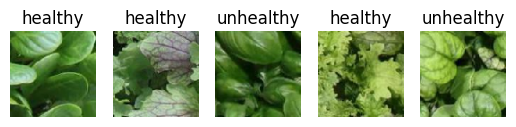

In [ ]:
# Display 5 image samples
num_samples = 5
# randomly select 5 pics to display with no replications
sample_indices = np.random.choice(len(X), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)

    # Normalize the image data to the range [0, 1]
    normalized_image = X[idx] / 255.0  # If your original pixel values are in [0, 255]

    plt.imshow(normalized_image)
    plt.title(y_cat[idx])
    plt.axis('off')

plt.show()

### 2 - Data Preprocessing

#### 2.1 - Label transoformation

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_cat)

print(pd.Series(y).value_counts())
print("-------")
print(y.shape)
# healthy -> 0
# unhealthy -> 1
labels = {0: 'healthy', 1:'unhealthy'}

0    3199
1    2001
Name: count, dtype: int64
-------
(5200,)


#### 2.2 - Outlier removal

##### solution

In [ ]:
# outlier detection function
def outlier(x):
    return (np.all(x==X[58]) or np.all(x==X[412]))

# Identify non-outlier indices
non_outlier_indices = ~np.array([outlier(x) for x in X])

outlier_indices = np.invert(non_outlier_indices)

outliers = X[outlier_indices]

# Create X and y arrays without outliers
X_no_outliers = X[non_outlier_indices]
y_no_outliers = y[non_outlier_indices]

print(X_no_outliers.shape)
print(pd.Series(y_no_outliers).value_counts())
print("-------")
print(y_no_outliers.shape)
# healthy -> 0
# unhealthy -> 1

(5004, 96, 96, 3)
0    3101
1    1903
Name: count, dtype: int64
-------
(5004,)


##### K-means clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

###### KneeElbow Analysis -> used to find a reasonable number of cluster K

In [ ]:
def KneeElbowAnalysis(x,max_k=20):
    k_values = range(1,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=k, n_init='auto').fit(x) for k in k_values]
    centroids = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1

    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.xticks(k_values)
    plt.plot(k_values, wcss, 'o-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'o-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('KMeans Clustering');


###### PCA with directly flattened image -> Detected only 98/196 outliers in one cluster

In [ ]:
num_images = X.shape[0]
flattened_images = X.reshape(num_images, -1)

pca = PCA(n_components = 0.9) # Retain 90% of the variance
pca_images = pca.fit_transform(flattened_images)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose K
cluster_labels = kmeans.fit_predict(pca_images)

In [ ]:
distances = kmeans.transform(pca_images)
distance_to_centroid = np.min(distances, axis=1)

(5200, 27648)
(5200, 319)
(5200,)
[[   0  834]
 [   1 1527]
 [   2   98]
 [   3 1379]
 [   4 1362]]
(5200, 5)
(5200,)


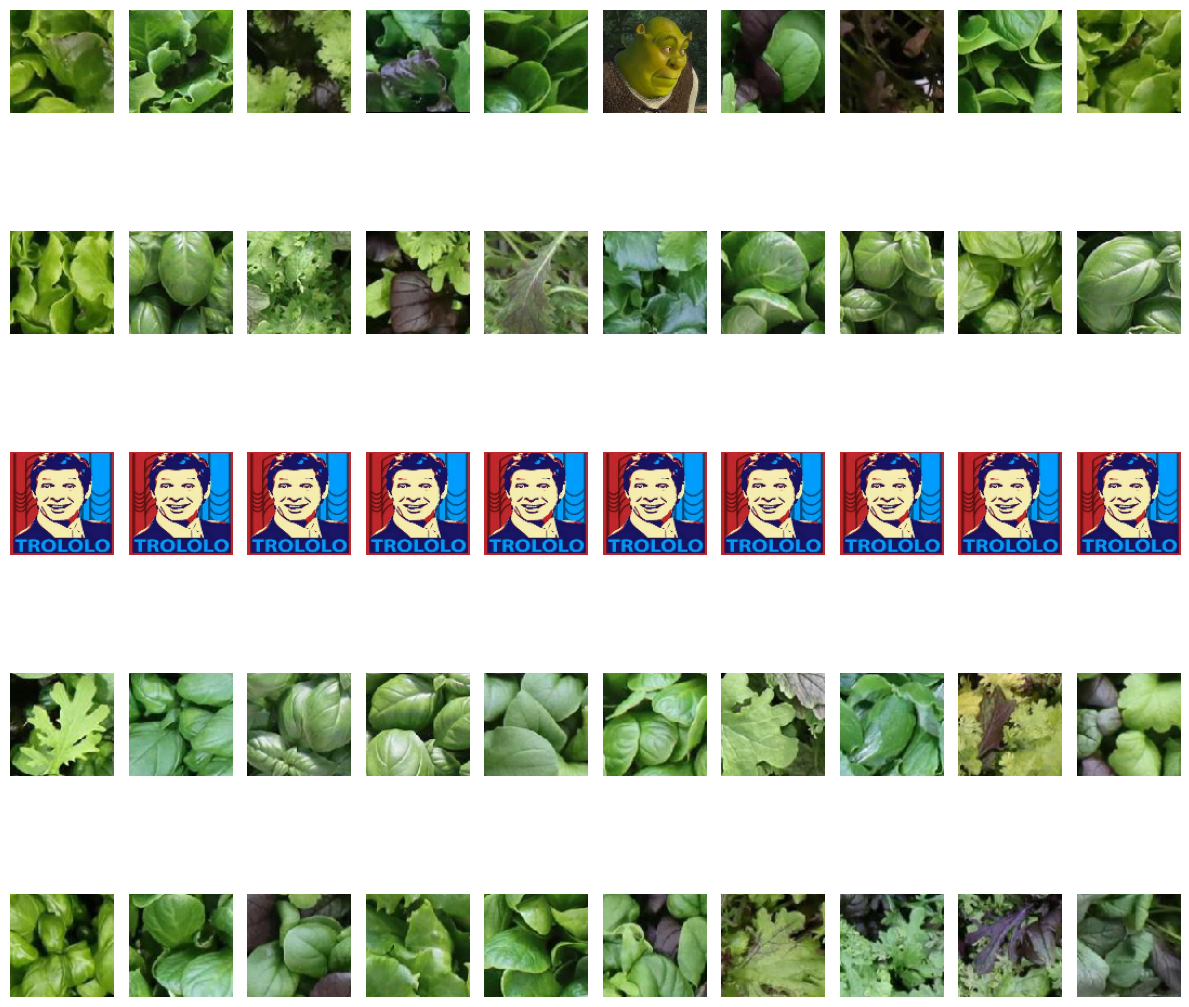

In [ ]:
print(flattened_images.shape) # each images is a flatten vector of 27648 pixel
print(pca_images.shape)    # pca reduced the dimension of vectors to 319 values
print(cluster_labels.shape)

clusters, counts = np.unique(cluster_labels, return_counts=True)
print(np.asarray((clusters, counts)).T)

cluster_index = [np.where(cluster_labels == cluster)[0] for cluster in clusters]

print(distances.shape)
print(distance_to_centroid.shape)

# Set up the figure and axes
fig, axes = plt.subplots(len(clusters), 10, figsize=(12, 12))  # 5x10 grid, adjust figsize as needed

for cluster in clusters:

  axes[cluster][0].set_ylabel(f"Cluster {cluster}", rotation=90, size='large')
  for i in range(10):  # Assuming there are 10 images per cluster
    axes[cluster, i].imshow(X[cluster_index[cluster][i]] / 255.0)  # Display the image
    axes[cluster, i].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [ ]:
# 5. Set a threshold for outliers based on distance
threshold = np.percentile(distance_to_centroid, 95)  # For example, 95th percentile
outliers = np.where(distance_to_centroid > threshold)[0]

print(f"Identified {len(outliers)} outliers")

Identified 260 outliers


[   0   24   40   56   89   94  112  134  155  160  168  208  218  260
  278  305  324  326  327  333  339  351  382  428  431  465  510  515
  547  584  606  618  620  626  627  649  656  741  765  792  797  800
  823  837  842  863  874  889  934  942 1000 1015 1030 1073 1082 1097
 1120 1128 1215 1222 1233 1261 1264 1290 1291 1294 1298 1392 1401 1406
 1434 1444 1490 1518 1540 1547 1550 1561 1564 1574 1587 1588 1600 1611
 1622 1641 1694 1715 1718 1733 1775 1797 1809 1813 1852 1893 1911 1913
 1915 1961 2041 2068 2070 2075 2082 2113 2154 2179 2197 2223 2225 2256
 2270 2310 2314 2327 2351 2361 2378 2392 2397 2434 2437 2448 2466 2467
 2490 2491 2512 2517 2551 2595 2625 2626 2658 2662 2708 2718 2728 2782
 2785 2795 2820 2873 2888 2948 2959 2964 2982 2989 3014 3042 3060 3172
 3192 3206 3298 3314 3324 3326 3364 3391 3394 3448 3454 3485 3509 3520
 3521 3526 3555 3558 3590 3618 3626 3668 3681 3682 3689 3717 3718 3760
 3791 3803 3838 3847 3859 3872 3884 3886 3908 3934 3955 3962 3965 4072
 4104 

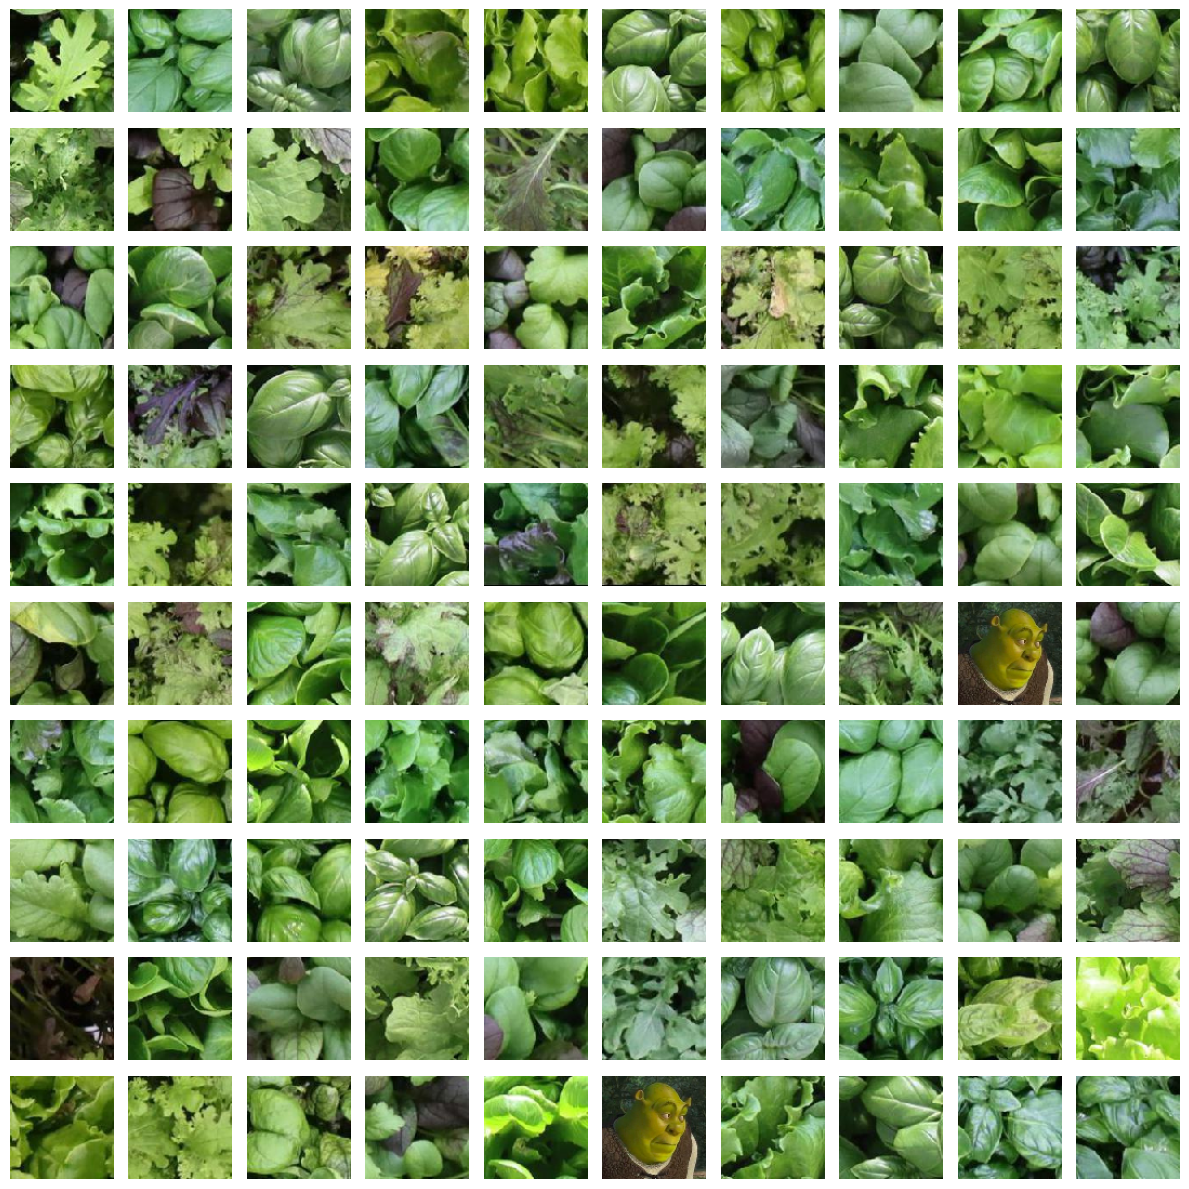

In [ ]:
print(outliers)

# Set up the figure and axes
fig, axes = plt.subplots(10, 10, figsize=(12, 12))  # 10x10 grid, adjust figsize as needed

# Plot each image in the 10x10 grid
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i]/255.0)  # Display the image
    ax.axis('off')  # Turn off axis labels

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [ ]:
# Optionally, visualize outliers
for idx in outliers:
    plt.imshow(X[idx])
    plt.show()

###### After feature extraction with MobileNetV3Small -> clustered all 196 outliers

In [ ]:
# for loading/processing the images
from keras import applications

In [ ]:
model = applications.MobileNetV3Small(include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    include_preprocessing=True,
    name="mobilenet_v3_small_minimalistic_1.0_224",)
image_features = model.predict(X)

163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step
(5200, 3, 3, 576)


In [ ]:
image_features = image_features.reshape(5200,-1)
print(X.shape)
print(image_features.shape)

(5200, 96, 96, 3)
(5200, 5184)


In [ ]:
pca = PCA(n_components = 0.9) # Retain 90% of the variance
pca_images = pca.fit_transform(image_features)

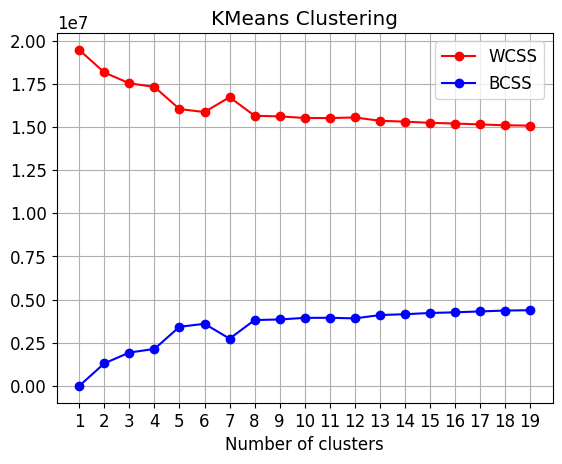

In [ ]:
KneeElbowAnalysis(pca_images, 20)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose K
cluster_labels = kmeans.fit_predict(pca_images)

distances = kmeans.transform(pca_images)
distance_to_centroid = np.min(distances, axis=1)

(5200, 1012)
(5200,)
(5200, 5)
(5200,)
[[   0 1708]
 [   1 1684]
 [   2   98]
 [   3   98]
 [   4 1612]]


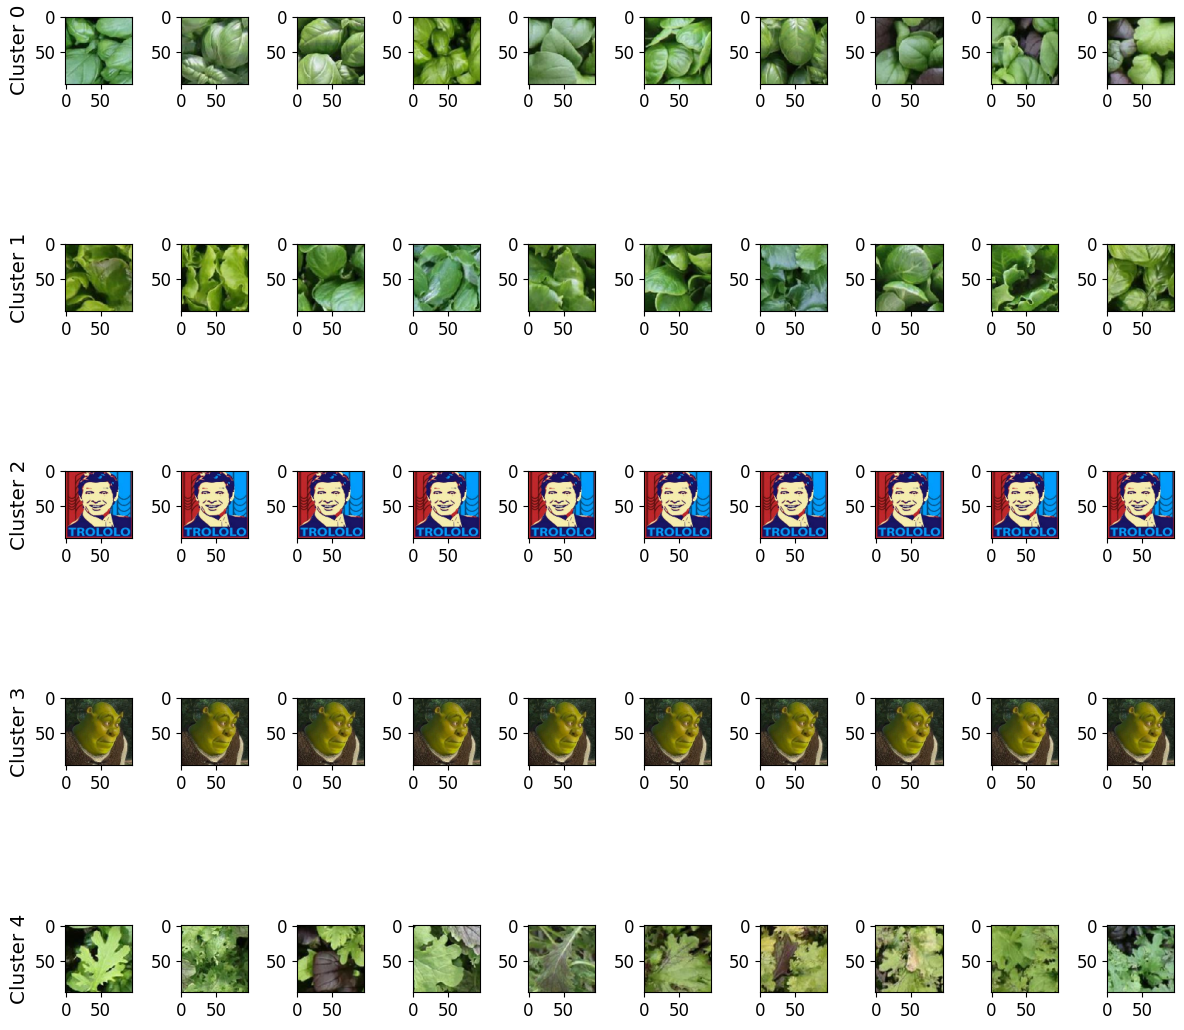

In [ ]:
print(pca_images.shape)
print(cluster_labels.shape)
print(distances.shape)
print(distance_to_centroid.shape)

clusters, counts = np.unique(cluster_labels, return_counts=True)
print(np.asarray((clusters, counts)).T)
cluster_index = [np.where(cluster_labels == cluster)[0] for cluster in clusters]

# Set up the figure and axes
fig, axes = plt.subplots(len(clusters), 10, figsize=(12, 12))  # 5x10 grid, adjust figsize as needed

for cluster in clusters:

  axes[cluster][0].set_ylabel(f"Cluster {cluster}", rotation=90, size='large')

  for i in range(10):  # showing only 10 images per cluster
    axes[cluster, i].imshow(X[cluster_index[cluster][i]] / 255.0)  # Display the image
    # axes[cluster, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(cluster_index[2].shape)
print(cluster_index[3].shape)
outliers_index = np.concatenate((cluster_index[2], cluster_index[3]))
print(outliers_index.shape)

mask = np.ones(len(X), dtype=bool)  # Start with all True
mask[outliers_index] = False  # Set outlier indices to False

print(X.shape)
# Apply the mask to the data array
X_no_outliers = X[mask]
y_no_outliers = y[mask]
print(X_no_outliers.shape)
print(y_no_outliers.shape)


(98,)
(98,)
(196,)
(5200, 96, 96, 3)
(5004, 96, 96, 3)
(5004,)


#### 2.3 - Data splitting

In [ ]:
# Random splitting Train Validation and Test
X_train, X_val_test, y_train, y_val_test = train_test_split(X_no_outliers, y_no_outliers, test_size = 0.2, random_state=seed, shuffle = True)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state=seed, shuffle = True )

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))
print(y_test.shape)

X_train shape: (4003, 96, 96, 3), y_train shape: (4003,)
X_val shape: (501, 96, 96, 3), y_val shape: (501,)
X_test shape: (500, 96, 96, 3), y_test shape: (500,)
(500, 2)


#### 2.4 - Class balancing - assigning higher weight to under-represented class

Synthetic Minority Over-sampling Techniques in case of images may create data points that are not realistic in the original image space.
Therefore other approaches to mitigate class unbalance are prefered, like assign weights to classes.

In [ ]:
labels, counts = np.unique(y_no_outliers, return_counts=True)
print(np.asarray((labels, counts)).T)
max_count = np.max(counts)

class_weight={label: max_count/count for label, count in zip(labels, counts)}
print(class_weight)


[[   0 3101]
 [   1 1903]]
{0: 1.0, 1: 1.6295323173935892}


### 3 - Model building

In [ ]:
input_shape = X[0].shape

# input layer
input_layer = tfkl.Input(shape = input_shape)


# preprocessing layer for data augmentation
data_augmentation = tfk.Sequential([
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomZoom((0,0.15),(0,0.15)),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.2, fill_mode='nearest'),
    tfkl.Resizing(input_shape[0], input_shape[1])
], name = 'Data_augmentation')

preprocess_layer = data_augmentation(input_layer)


# transfer learning from Pre-trained model
supernet = tfk.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape
)

x = supernet(preprocess_layer)


# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = tfkl.GlobalAveragePooling2D()(x)

# Additional Dense Layer for adding more non-linearity
x = tfkl.Dense(
    units = 128,
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(x)

# Dropout layer
x = tfkl.Dropout(0.3, seed=seed)(x)

# Output layer with two neurons
output_layer = (tfkl.Dense(
    units = 2,
    activation = 'softmax',
    name = 'output',
    # Initializer for the kernel weights matrix
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
))(x)

#Final model
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='EfficientNet')

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data augmentation (Sequential)       │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 3, 3, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,083,538 (23.21 MB)

 Trainable params: 6,022,930 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

### 4 - Model training

#### 4.1 - Hyperparameters configuration

In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 32
epochs = 500
learning_rate = 1e-5
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

# Defining Parameters
loss = tfk.losses.BinaryCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate,epsilon=1e-2)
metrics = ['accuracy']

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

Batch Size: 32, Epochs: 500, Learning Rate: 1e-05
Input Shape: (96, 96, 3), Output Shape: 4003


#### 4.2 - Training

In [ ]:
# Define callback functions for early stopping and learning rate reduction and Model Check Point
save_dir = os.path.join('experiments')

callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=25, min_lr=1e-6, mode='max'),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, 'epoch{epoch:02d}.keras'),
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,# True to save only the best epoch
                                                     monitor='val_accuracy')
]

In [ ]:
# Training the model
# we do not use preprocessing functions because EfficientNetV2 does not require any
tl_history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    epochs = 500,
    batch_size = batch_size,
    shuffle = True,
    verbose = 1,
    class_weight = class_weight,
    callbacks = callbacks
).history

model.save("EfficientNevV2_ES_LR.keras")

Epoch 1/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 288ms/step - accuracy: 0.5988 - loss: 0.6826 - val_accuracy: 0.6031 - val_loss: 0.6856 - learning_rate: 1.0000e-05
Epoch 2/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 289ms/step - accuracy: 0.5998 - loss: 0.6809 - val_accuracy: 0.6075 - val_loss: 0.6837 - learning_rate: 1.0000e-05
Epoch 3/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy: 0.5817 - loss: 0.6862 - val_accuracy: 0.6031 - val_loss: 0.6819 - learning_rate: 1.0000e-05
Epoch 4/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.6112 - loss: 0.6787 - val_accuracy: 0.6075 - val_loss: 0.6806 - learning_rate: 1.0000e-05
Epoch 5/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.6037 - loss: 0.6733 - val_accuracy: 0.6186 - val_loss: 0.6790 - learning_rate: 1.0000e-05
Epoch 6/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 270ms/step - accuracy: 0.6089 - loss: 0.6746 - val_accuracy: 0.6164 - val_loss: 0.6778 - learning_rate: 1.0000e-05
Epoch 7/500
127/127 ━━━━━━━━━━━━━━━━━━━━

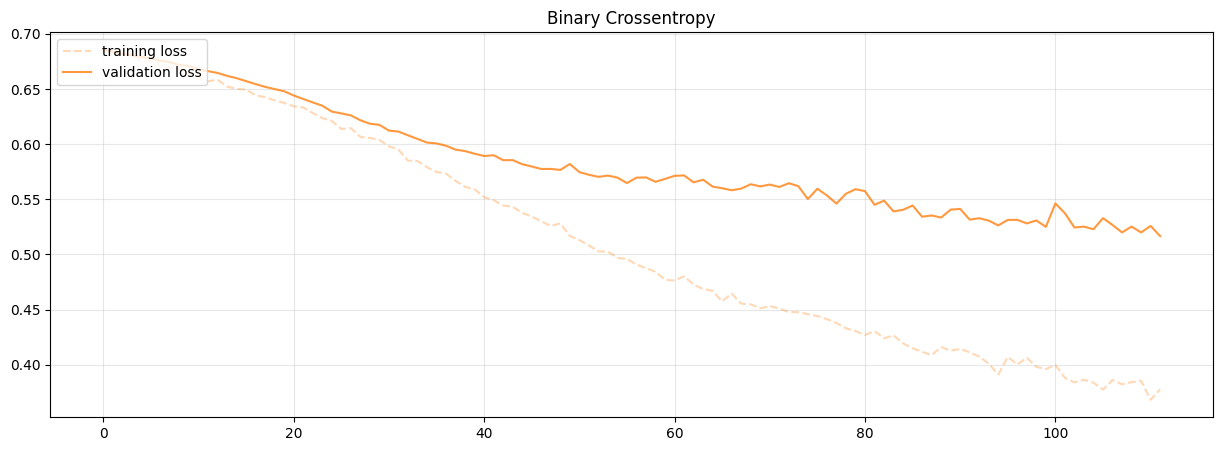

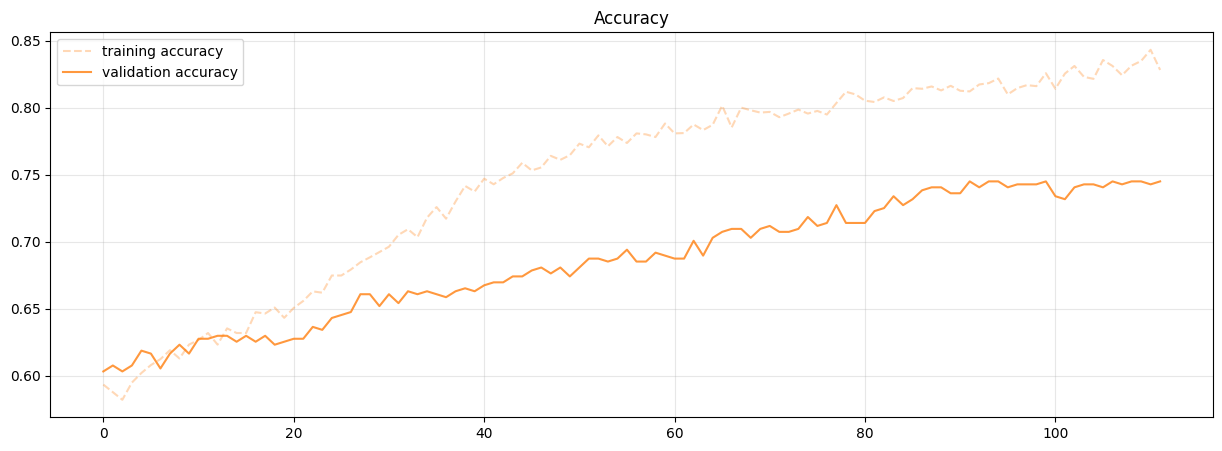

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)


plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#### 4.3 - Fine tuning

In [ ]:
# Load the model for fine tuning and print the summary
ft_model = tfk.models.load_model('EfficientNevV2_ES_LR.keras')
ft_model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,129,400 (69.16 MB)

 Trainable params: 6,022,930 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

 Optimizer params: 12,045,862 (45.95 MB)

In [ ]:
# Set all layers of the pretrained model equal to true
# Freeze first N layers
N = 176
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
  if(i<=N):
    layer.trainable=False
  else:
    layer.trainable=True
  print(i, layer.name, layer.trainable)

ft_model.summary()

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,129,400 (69.16 MB)

 Trainable params: 3,829,666 (14.61 MB)

 Non-trainable params: 2,253,872 (8.60 MB)

 Optimizer params: 12,045,862 (45.95 MB)

In [ ]:
# Defining Parameters
loss = tfk.losses.BinaryCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate,epsilon=1e-2)
metrics = ['accuracy']

# Compile the model with a lower learning rate
ft_model.compile(
    optimizer = tfk.optimizers.Adam(learning_rate = 5e-6, epsilon = 1e-2),
    loss = loss,
    metrics = metrics
)

# Define callback functions for early stopping and learning rate reduction and Model Check Point
save_dir = os.path.join('experiments')

callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=25, min_lr=1e-6, mode='max'),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, 'epoch{epoch:02d}.keras'),
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,# True to save only the best epoch
                                                     monitor='val_accuracy')
]


In [ ]:
class_weight

[{0: 1.0}, {1: 1.6295323173935892}]

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    batch_size = 32,
    epochs = 300,
    class_weight = class_weight,
    callbacks = callbacks
).history

model.save("EfficientNevV2_ES_LR_FT.keras")

Epoch 1/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 62s 244ms/step - accuracy: 0.8240 - loss: 0.5257 - val_accuracy: 0.7325 - val_loss: 0.5392 - learning_rate: 5.0000e-06
Epoch 2/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.8182 - loss: 0.5398 - val_accuracy: 0.7385 - val_loss: 0.5336 - learning_rate: 5.0000e-06
Epoch 3/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.8276 - loss: 0.5137 - val_accuracy: 0.7345 - val_loss: 0.5385 - learning_rate: 5.0000e-06
Epoch 4/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.8154 - loss: 0.5298 - val_accuracy: 0.7325 - val_loss: 0.5363 - learning_rate: 5.0000e-06
Epoch 5/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.8297 - loss: 0.5142 - val_accuracy: 0.7445 - val_loss: 0.5277 - learning_rate: 5.0000e-06
Epoch 6/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.8160 - loss: 0.5237 - val_accuracy: 0.7445 - val_loss: 0.5205 - learning_rate: 5.0000e-06
Epoch 7/300
126/126 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
#plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
# plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
# plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
#plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
# plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
# plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)


In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(X_test,y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

### 5 - Model evaluation with/out Test Time Data Augmentation

#### EfficientNevV2_ES_LR_FT model

In [ ]:
# Load the best model from directory
saved_model = tfk.models.load_model('EfficientNevV2_ES_LR_FT.keras')

##### 5.1 - without TTDA

In [ ]:
predictions = saved_model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step


Accuracy: 0.628
Precision: 0.5821
Recall: 0.5102
F1: 0.4231


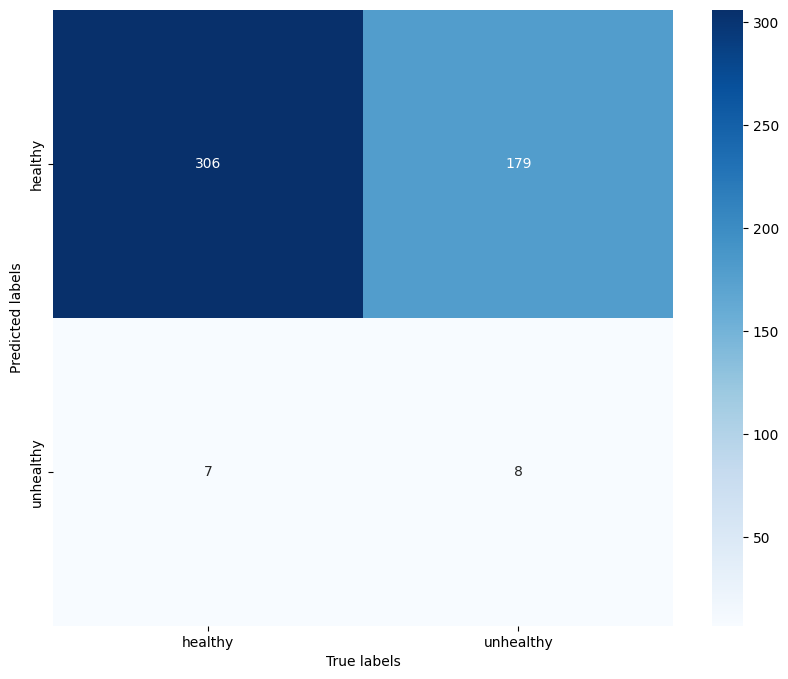

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1:', round(f1, 4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

##### 5.2 - with TTDA

In [ ]:
from tqdm.notebook import tqdm_notebook

def predict_ttda(X, model):
  preprocessing = tfk.Sequential([
    tfkl.RandomFlip('horizontal',name='RandomFlip_horizontal'),
    tfkl.RandomFlip('vertical',name='RandomFlip_vertical'),
    tfkl.RandomBrightness(0.1)
    #tfkl.RandomZoom(0.2),
    #tfkl.RandomTranslation(0.2,0.2),
    ], name = 'preprocessing')

  out = []

  for idx in tqdm_notebook(range(X.shape[0])):

      x = X[idx]

      images_to_predict = []
      images_to_predict.append(x)

      for i in range(10):
          augment_image = preprocessing(x)
          #augment_image = datagenerator.random_transform(x)
          images_to_predict.append(augment_image)

      images_to_predict = np.array(images_to_predict)
      predictions = model.predict(images_to_predict, verbose=0)
      mean_prediction = np.mean(predictions, axis=0)
      out.append(mean_prediction)

  return tf.stack(out)

Accuracy: 0.624
Precision: 0.5359
Recall: 0.5027
F1: 0.4035


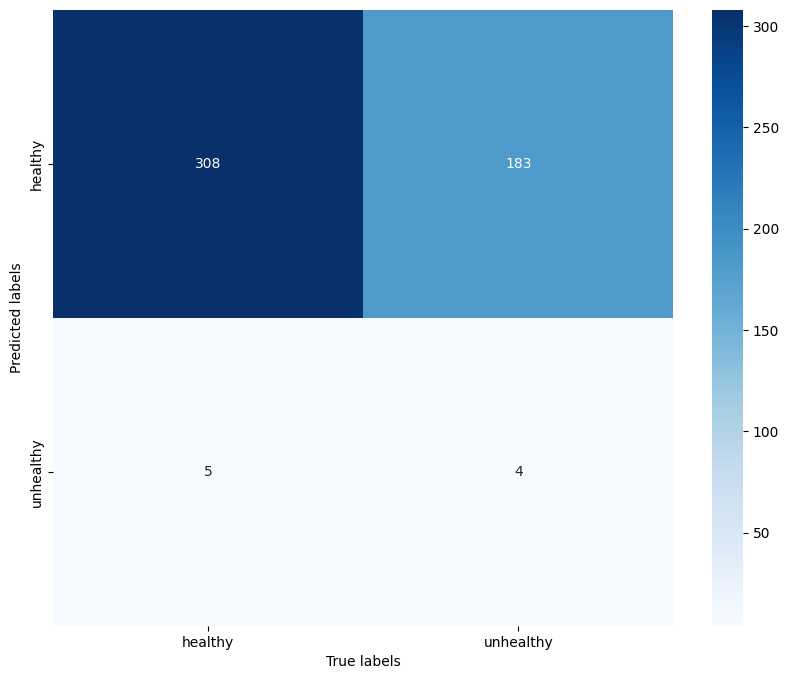

In [ ]:
predictions = predict_ttda(X_test, saved_model)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1:', round(f1, 4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### EfficientNevV2_ES_LR model

In [ ]:
# Load the best model from directory
saved_model = tfk.models.load_model('EfficientNevV2_ES_LR.keras')

##### 5.1 - without TTDA

In [ ]:
predictions = saved_model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


Accuracy: 0.756
Precision: 0.8528
Recall: 0.6749
F1: 0.6781


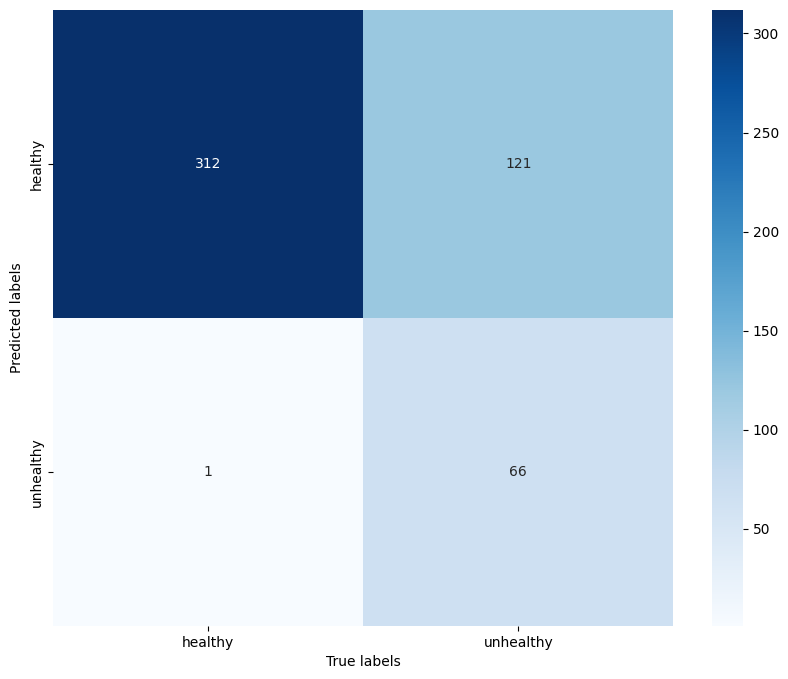

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1:', round(f1, 4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

##### 5.2 - with TTDA

In [ ]:
from tqdm.notebook import tqdm_notebook

def predict_ttda(X, model):
  preprocessing = tfk.Sequential([
    tfkl.RandomFlip('horizontal',name='RandomFlip_horizontal'),
    tfkl.RandomFlip('vertical',name='RandomFlip_vertical'),
    tfkl.RandomBrightness(0.1)
    #tfkl.RandomZoom(0.2),
    #tfkl.RandomTranslation(0.2,0.2),
    ], name = 'preprocessing')

  out = []

  for idx in tqdm_notebook(range(X.shape[0])):

      x = X[idx]

      images_to_predict = []
      images_to_predict.append(x)

      for i in range(10):
          augment_image = preprocessing(x)
          #augment_image = datagenerator.random_transform(x)
          images_to_predict.append(augment_image)

      images_to_predict = np.array(images_to_predict)
      predictions = model.predict(images_to_predict, verbose=0)
      mean_prediction = np.mean(predictions, axis=0)
      out.append(mean_prediction)

  return tf.stack(out)

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 0.742
Precision: 0.8462
Recall: 0.6562
F1: 0.6532


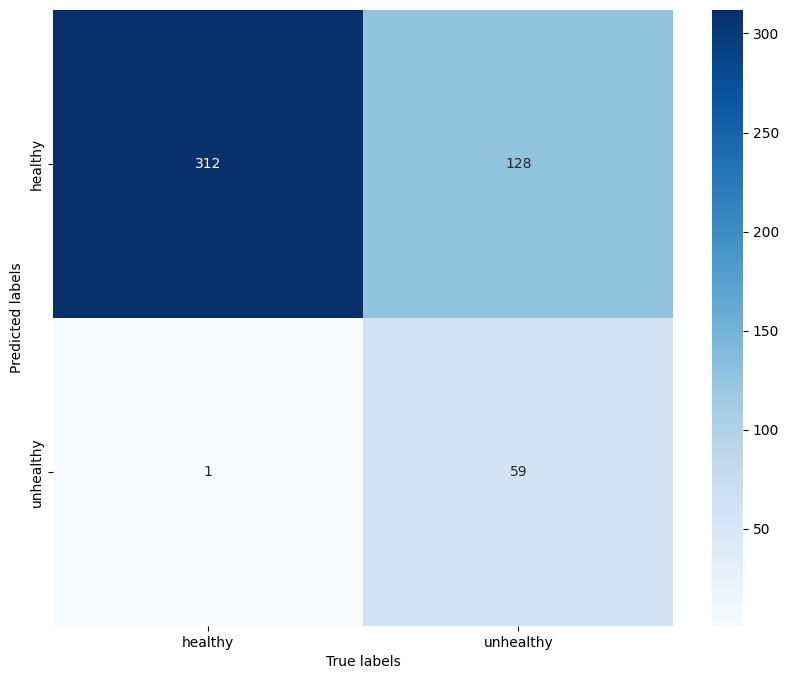

In [ ]:
predictions = predict_ttda(X_test, saved_model)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1:', round(f1, 4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 5.3 - Data Visualization

We can visualize what are the images that our model mispredicted

In [ ]:
def visualize_data(images, categories=None, class_names=None):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(min(3 * 7, len(images))):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        if class_names and categories is not None:
            class_index = categories[i].argmax()
            plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
#true classes
t = np.argmax(y_test, axis=-1)

#predicted classes
p = np.argmax(predictions_ttda, axis=-1)

#mispredicted indices
miss_indices = np.where(t!=p)
print(miss_indices)

In [ ]:
# visualize mispredicted data
mispred = np.array([x for x in X[miss_indices]])
visualize_data(mispred[(21*1):]/255)
visualize_data(mispred[(21*2):]/255)
visualize_data(mispred[(21*3):]/255)